# Program to demonstrate the working of the decision tree based ID3 algorithm.

### Example 1

In [9]:
import math
import pandas as pd
from operator import itemgetter

In [10]:
class DecisionTree:
    def __init__(self, df, target, positive, parent_val, parent):
        self.data = df
        self.target = target
        self.positive = positive
        self.parent_val = parent_val
        self.parent = parent
        self.childs = []
        self.decision = ''

    def _get_entropy(self, data):
        p = sum(data[self.target]==self.positive)
        n = data.shape[0] - p
        p_ratio = p/(p+n)
        n_ratio = 1 - p_ratio
        entropy_p = -p_ratio*math.log2(p_ratio) if p_ratio != 0 else 0
        entropy_n = - n_ratio*math.log2(n_ratio) if n_ratio !=0 else 0
        return entropy_p + entropy_n
    
    def _get_gain(self, feat):
        avg_info=0
        for val in self.data[feat].unique():
            avg_info+=self._get_entropy(self.data[self.data[feat] == val])*sum(self.data[feat]==val)/self.data.shape[0]
        return self._get_entropy(df) - avg_info
    
    def _get_splitter(self):
        self.splitter = max(self.gains, key = itemgetter(1))[0] 
    
    def update_nodes(self):
        self.features = [col for col in self.data.columns if col != self.target]
        self.entropy = self._get_entropy(self.data)
        if self.entropy != 0:
            self.gains = [(feat, self._get_gain(feat)) for feat in self.features]
            self._get_splitter()
            residual_columns = [k for k in self.data.columns if k != self.splitter]
            for val in self.data[self.splitter].unique():
                df_tmp = self.data[self.data[self.splitter]==val][residual_columns]
                tmp_node = DecisionTree(df_tmp, self.target, self.positive, val, self.splitter)
                tmp_node.update_nodes()
                self.childs.append(tmp_node)

In [11]:
df = pd.read_csv('id3.csv')
df

,Outlook,Temperature,Humidity,WindSpeed,Play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rainy,Mild,High,Weak,Yes
4,Rainy,Cool,Normal,Weak,Yes
5,Rainy,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rainy,Mild,Normal,Weak,Yes


In [12]:
def print_tree(n):
    for child in n.childs:
        if child:
            print(child.__dict__.get('parent', ''))
            print(child.__dict__.get('parent_val', ''), '\n')
            print_tree(child)

In [13]:
dt = DecisionTree(df, 'Play', 'Yes', '', '')
dt.update_nodes()

In [14]:
print_tree(dt)

Outlook
Sunny 

Humidity
High 

Humidity
Normal 

Outlook
Overcast 

Outlook
Rainy 

WindSpeed
Weak 

WindSpeed
Strong 



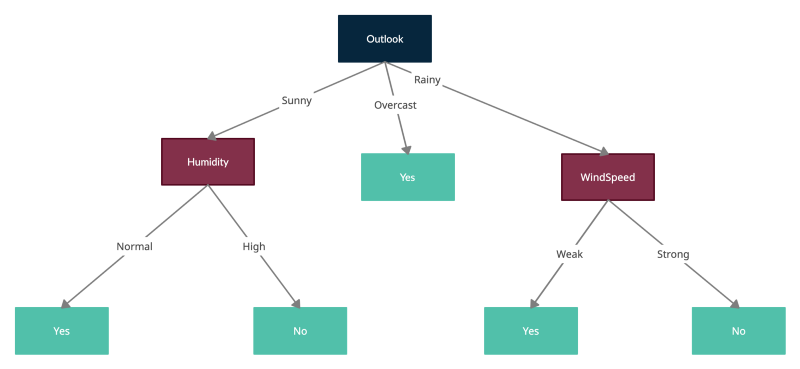

### Example 2

In [15]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris 
from sklearn.tree import DecisionTreeClassifier, plot_tree


iris = load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [16]:
def compute_entropy(y):
    if len(y) < 2:
        return 0
    freq = np.array( y.value_counts(normalize=True) )
    return -(freq * np.log2(freq + 1e-6)).sum() 
    
def compute_info_gain(samples, attr, target):
    values = samples[attr].value_counts(normalize=True)
    split_ent = 0
    for v, fr in values.iteritems():
        index = samples[attr]==v
        sub_ent = compute_entropy(target[index])
        split_ent += fr * sub_ent
    
    ent = compute_entropy(target)
    return ent - split_ent

class TreeNode:
    def __init__(self, node_name="", min_sample_num=10, default_decision=None):
        self.children = {} 
        self.decision = None 
        self.split_feat_name = None
        self.name = node_name
        self.default_decision = default_decision
        self.min_sample_num = min_sample_num

    def pretty_print(self, prefix=''):
        if self.split_feat_name is not None:
            for k, v in self.children.items():
                v.pretty_print(f"{prefix}:When {self.split_feat_name} is {k}")
        else:
            print(f"{prefix}:{self.decision}")

    def predict(self, sample):
        if self.decision is not None:
            print("Decision:", self.decision)
            return self.decision
        else: 
            attr_val = sample[self.split_feat_name]
            child = self.children[attr_val]
            print("Testing ", self.split_feat_name, "->", attr_val)
            return child.predict(sample)

    def fit(self, X, y):
        if self.default_decision is None:
            self.default_decision = y.mode()[0]
               
        print(self.name, "received", len(X), "samples")
        if len(X) < self.min_sample_num:
            if len(X) == 0:
                self.decision = self.default_decision
                print("DECISION", self.decision)
            else:
                self.decision = y.mode()[0]
                print("DECISION", self.decision)
            return
        else: 
            unique_values = y.unique()
            if len(unique_values) == 1:
                self.decision = unique_values[0]
                print("DECISION", self.decision)
                return
            else:
                info_gain_max = 0
                for a in X.keys(): 
                    aig = compute_info_gain(X, a, y)
                    if aig > info_gain_max:
                        info_gain_max = aig
                        self.split_feat_name = a
                print(f"Split by {self.split_feat_name}, IG: {info_gain_max:.2f}")
                self.children = {}
                for v in X[self.split_feat_name].unique():
                    index = X[self.split_feat_name] == v
                    self.children[v] = TreeNode(
                        node_name=self.name + ":" + self.split_feat_name + "==" + str(v),
                        min_sample_num=self.min_sample_num,
                        default_decision=self.default_decision)
                    self.children[v].fit(X[index], y[index])

In [38]:
X = df.drop( "target", axis = 1)
y = df["target"]

t = TreeNode(min_sample_num=50)
t.fit(X, y)

attributes = ["sepal length (cm)","sepal width (cm)","petal length (cm)","petal width (cm)"]
new_attributes = []
for a in attributes:
    new_a = "Quant4." + a
    df[new_a] = pd.qcut(df[a], q=4, labels=["q1", "q2", "q3", "q4"])
    new_attributes.append(new_a)

 received 150 samples
Split by petal length (cm), IG: 1.45
:petal length (cm)==1.4 received 13 samples
DECISION 0.0
:petal length (cm)==1.3 received 7 samples
DECISION 0.0
:petal length (cm)==1.5 received 13 samples
DECISION 0.0
:petal length (cm)==1.7 received 4 samples
DECISION 0.0
:petal length (cm)==1.6 received 7 samples
DECISION 0.0
:petal length (cm)==1.1 received 1 samples
DECISION 0.0
:petal length (cm)==1.2 received 2 samples
DECISION 0.0
:petal length (cm)==1.0 received 1 samples
DECISION 0.0
:petal length (cm)==1.9 received 2 samples
DECISION 0.0
:petal length (cm)==4.7 received 5 samples
DECISION 1.0
:petal length (cm)==4.5 received 8 samples
DECISION 1.0
:petal length (cm)==4.9 received 5 samples
DECISION 2.0
:petal length (cm)==4.0 received 5 samples
DECISION 1.0
:petal length (cm)==4.6 received 3 samples
DECISION 1.0
:petal length (cm)==3.3 received 2 samples
DECISION 1.0
:petal length (cm)==3.9 received 3 samples
DECISION 1.0
:petal length (cm)==3.5 received 2 samples


In [34]:
X = df[new_attributes]
y = df["target"]

t = TreeNode(min_sample_num=50)
t.fit(X, y)

 received 150 samples
Split by Quant4.petal length (cm), IG: 1.17
:Quant4.petal length (cm)==q1 received 44 samples
DECISION 0.0
:Quant4.petal length (cm)==q2 received 31 samples
DECISION 1.0
:Quant4.petal length (cm)==q3 received 41 samples
DECISION 1.0
:Quant4.petal length (cm)==q4 received 34 samples
DECISION 2.0


In [39]:
corr = 0
err_fp = 0
err_fn = 0
for (i, ct), tgt in zip(X.iterrows(), y):
    a = t.predict(ct)
    if a and not tgt:
        err_fp += 1
    elif not a and tgt:
        err_fn += 1
    else:
        corr += 1

Testing  petal length (cm) -> 1.4
Decision: 0.0
Testing  petal length (cm) -> 1.4
Decision: 0.0
Testing  petal length (cm) -> 1.3
Decision: 0.0
Testing  petal length (cm) -> 1.5
Decision: 0.0
Testing  petal length (cm) -> 1.4
Decision: 0.0
Testing  petal length (cm) -> 1.7
Decision: 0.0
Testing  petal length (cm) -> 1.4
Decision: 0.0
Testing  petal length (cm) -> 1.5
Decision: 0.0
Testing  petal length (cm) -> 1.4
Decision: 0.0
Testing  petal length (cm) -> 1.5
Decision: 0.0
Testing  petal length (cm) -> 1.5
Decision: 0.0
Testing  petal length (cm) -> 1.6
Decision: 0.0
Testing  petal length (cm) -> 1.4
Decision: 0.0
Testing  petal length (cm) -> 1.1
Decision: 0.0
Testing  petal length (cm) -> 1.2
Decision: 0.0
Testing  petal length (cm) -> 1.5
Decision: 0.0
Testing  petal length (cm) -> 1.3
Decision: 0.0
Testing  petal length (cm) -> 1.4
Decision: 0.0
Testing  petal length (cm) -> 1.7
Decision: 0.0
Testing  petal length (cm) -> 1.5
Decision: 0.0
Testing  petal length (cm) -> 1.7
Decisi

In [22]:
corr, err_fp, err_fn

(144, 6, 0)

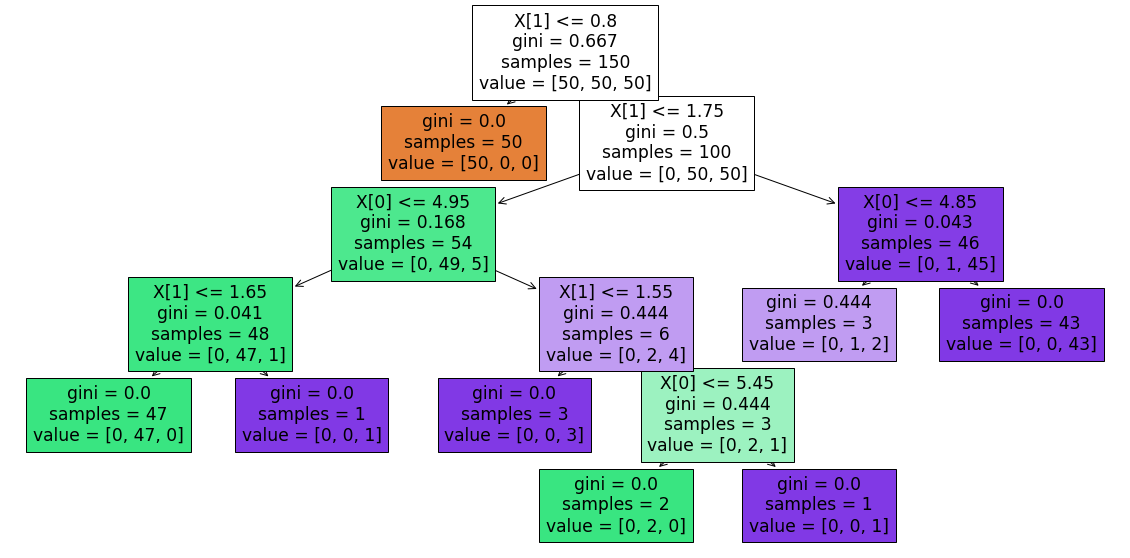

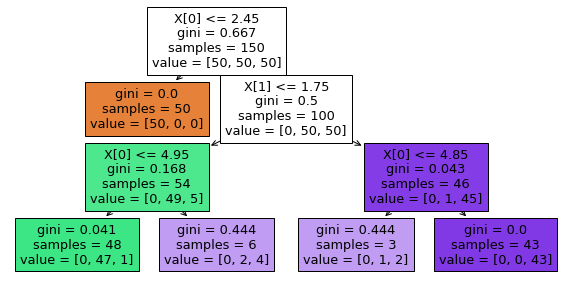

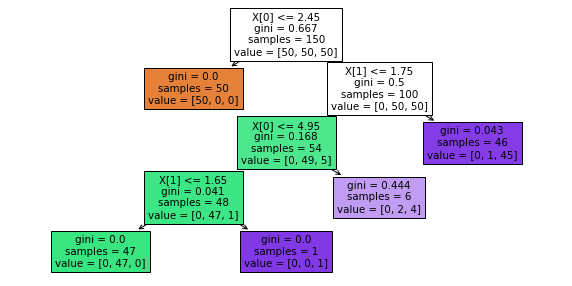

In [30]:
show_parms = DecisionTreeClassifier().fit(X, y)
plt.figure(figsize = (20,10))
plot_tree(show_parms, filled=True)

show_parms_max_depth_3 = DecisionTreeClassifier(max_depth=3).fit(X, y)
plt.figure(figsize = (10,5))
plot_tree(show_parms_max_depth_3, filled=True)

show_parms_max_depth_3 = DecisionTreeClassifier(min_impurity_decrease=0.01).fit(X, y)
plt.figure(figsize = (10,5))
plot_tree(show_parms_max_depth_3, filled=True)
plt.show()